In [1]:
from pathlib import Path
from os.path import abspath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

# Load Data & Preprocess

## Exercise 1:
Do some exploratory data analysis. Don’t just look globally, also look at these metrics by class (if applicable). There might be differences, after all: 
- How many missing data are there? 
- Are there other strange values in the data? 
- What is the proportion of classes in your data? 
- Are there genes (features) that are extremely highly correlated with each other? If so, how many?
- What is the maximum value in the data, and the minimum? 
- Which feature has the highest variance? 
- Finally, make a boxplot of the expression values of the 30 features with the highest variance in the dataset, ordered by this variance. 

I expect a short comment on/answer to all these questions and what you found in your notebook, as well as the requested boxplot.

In [2]:
home_path = Path(abspath(''))
train_data_path = home_path.joinpath('data/train_2025.csv')
test_data_path = home_path.joinpath('data/test_2025.csv')
test_answers_path = home_path.joinpath('data/answer_key_2025.csv')

In [3]:
X_dataframe = pd.read_csv(train_data_path)
test_X_dataframe = pd.read_csv(test_data_path)
test_y_dataframe = pd.read_csv(test_answers_path)

In [4]:
X_dataframe.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641


In [4]:
# Seperate features and target variable
target_name = 'Outcome'
labels = X_dataframe[target_name]
features = X_dataframe.drop([target_name, 'Id'], axis=1) 

test_labels = test_y_dataframe.drop('Id', axis=1)
test_features = test_X_dataframe.drop('Id', axis=1)

### Missing data & Strange values

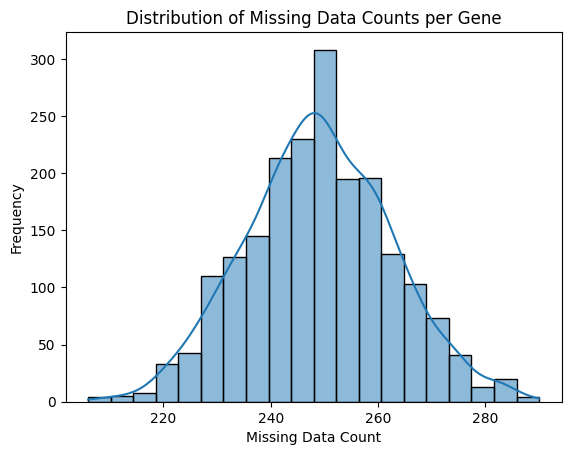

Total missing values across all features: 497869
This means that 7.07% of data points are missing

Total infinite values: 0
Total negative values: 0
Total 0.0 values: 1885


In [6]:
# Checking for missing values
missing_counts = features.isna().sum()

# Create a distribution plot
sns.histplot(missing_counts, kde=True, bins=20)
plt.xlabel('Missing Data Count')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data Counts per Gene')
plt.show()

print(f'Total missing values across all features: {missing_counts.sum()}')
print(f'This means that {round((missing_counts.sum() / (features.shape[0] * features.shape[1]) * 100), 2)}% of data points are missing')

print()

# Checking for strange values
num_infinite = np.isinf(features.values).sum()
num_negative = (features < 0).sum().sum()
num_zero = (features == 0.0).sum().sum()
print(f'Total infinite values: {num_infinite}')
print(f'Total negative values: {num_negative}')
print(f'Total 0.0 values: {num_zero}')

In the figure the distribution of missing data points per feature is plotted. We can see of all the features that have missing data points most are missing around 250 data points.

### Class proportion
The dataset can used to train a classifier to classify 4 subtypes of lung cancer. For classification it's important that the class distribution in the training data is as equal to the actual class distribution. Here we check how the different classes are distributed in the dataset

In [7]:
class_counts = labels.value_counts()
print('Class counts:')
print(class_counts)
print()
for i in range (4):
    print(f'The percentage of class {i} is {round((class_counts / class_counts.sum())[i]*100, 2)}%')

Class counts:
Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64

The percentage of class 0 is 17.87%
The percentage of class 1 is 20.74%
The percentage of class 2 is 25.03%
The percentage of class 3 is 36.36%


### Checking for multicollinearity
It’s highly likely that measured genes are correlated with each other. Groups of genes form systems together that enable cell 'behavior'; thus, groups of genes can have high or low expression together by being part of the same system. However, this correlation with each other is not favorable for a classifier because the expression of these correlated genes doesn’t hold extra information that can be used to discriminate samples from each other.

In [8]:
# checking for high correlation between features.
corr_matrix = features.corr().abs() # Might take a while
threshold = 0.95 
high_corr_pairs = []
all_correlations = []
cols = corr_matrix.columns

# count only unique pairs 
for i in range(len(cols)):
    for j in range(i + 1, len(cols)): # go across diagnal
        # Store all values for plot
        all_correlations.append(corr_matrix.iloc[i, j])
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

In [9]:
# Printing results
print(f'Number of gene pairs that exceed the corraltion threshold: {len(high_corr_pairs)}')

Number of gene pairs that exceed the corraltion threshold: 59


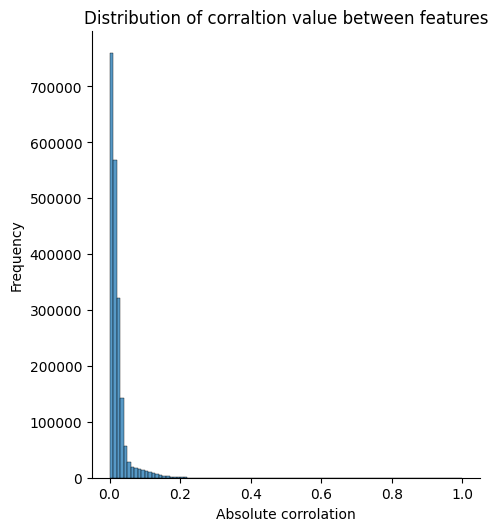

In [10]:
sns.displot(all_correlations, bins=100)
plt.xlabel('Absolute corrolation')
plt.ylabel('Frequency')
plt.title('Distribution of corraltion value between features')
plt.show()

Most gene pairs don't have high correlation with each other and after a correltion of about 0.2 there is a almost non existent tail of genes with a higher correlation. These genes might be of interest to exclude for our classificaton task.

### Data Range

In [11]:
print(f"Maximum value in the data: {features.max().max()}")
print(f"Minimum value in the data: {features.min().min()}")

Maximum value in the data: 51663.0
Minimum value in the data: 0.0


### Feature Variance

In [12]:
variances = features.var()
top_feature = variances.idxmax()
print(f'Feature with the highest variance: {top_feature}, with a variance value of: {round(variances.max(), 2)}')

Feature with the highest variance: Gene 1127, with a variance value of: 44663714.33


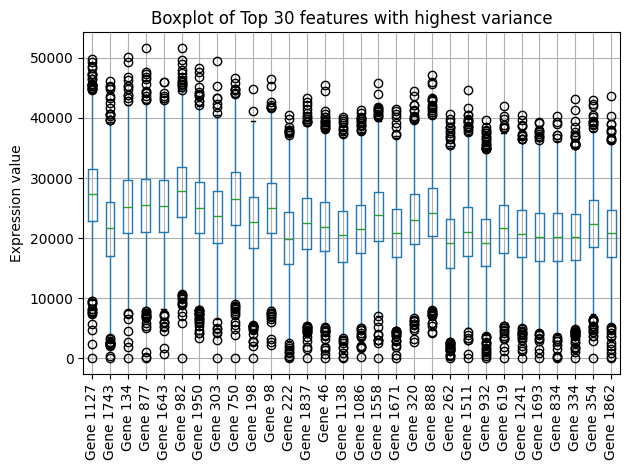

In [13]:
# boxplot of the top 30 features with highest variance.
top30_features = variances.sort_values(ascending=False).head(30).index

features[top30_features].boxplot(rot=90)
plt.title("Boxplot of Top 30 features with highest variance")
plt.ylabel("Expression value")
plt.tight_layout()
plt.show()

# Downsample data
2.	Big surprise: there’s missing data. Before you deal with that, take care of the class imbalance problem in the brute-force way described above: downsample the data so that you have equal numbers of data for each class. Continue with that training data to the following steps.

Clearly print the head and tail of the new training data (and labels) and show that it has equal amounts of each class.

In [5]:
from imblearn.under_sampling import RandomUnderSampler

sampled = RandomUnderSampler(random_state=42)
X_downSampled, y_downSampled = sampled.fit_resample(features, labels)

# Checking:
class_counts = y_downSampled.value_counts()
print('Class counts:')
print(class_counts)

Class counts:
Outcome
0    629
1    629
2    629
3    629
Name: count, dtype: int64


# 9. Random forest
- exercises:
    - Write down in one or two paragraphs how a RF works, mentioning what the Gini impurity is and how it is used, and how bootstrapping per tree and random feature subsampling per split are used to automatically combat overfitting. ✅
    - Report the following:
        - The cross validation performances (AUC ROC OVR, F1 macro) of the Random Forest classifier. ✅
        - How much better or worse then regularised logistic regression the RF classifier performs ❌
        - The 5 features that had the highest feature importance (and the associated feature importances) in the final RF trained on all training data. ✅
        - A plot for each of these 5 features that shows the distribution of the feature split by class in the training data (see this). ✅


- no feature scaling applied
- look into which features are reported as important and maybe compare to other methods?

A random forest is a collection of decision trees that together form an ensemble classification or regression method. A singular decision tree classifies samples by ‘asking questions’ such as ‘is feature A greater than 10?’ or ‘is feature B true?’. The order in which these questions are asked significantly impacts the final classification, as each question splits the data. To determine the order of nodes in the decision tree, the metric Gini impurity is used. Gini impurity measures how well a node splits the data, with lower values indicating a purer split. Features that result in lower Gini impurity are placed higher in the tree. 
While this helps create a good decision tree, a single tree alone does not generalize well. 

To improve generalization, a random forest combines multiple decision trees while introducing randomness. This is done through bootstrapping, where each tree is trained on a randomly selected subset of the data, allowing some samples to appear more than once. Additionally at each node, a random subset of features is considered, rather than considering all features. This results in a collection of different decision trees, each making slightly different classifications for the same sample. The final prediction is determined by majority vote, ensuring a more robust and reliable classification.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, f1_score, accuracy
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [9]:
global_seed = 42

In [17]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_downSampled, y_downSampled, train_size=0.8, test_size=0.2, stratify=y_downSampled, random_state=global_seed)

In [18]:
# Initialise pipeline 

# Required by exercise
# n_estimators=250 
# n_jobs=-2 to use all but one CPU to speed up the fitting
rfc = RandomForestClassifier(
    n_estimators=250, 
    criterion='gini',
    n_jobs=-2,
    random_state=global_seed
)

pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('random_forest', rfc)
])
pipe.fit(X_train, y_train)

# Which metrics to use
# See total list: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scoring = ['roc_auc_ovr','f1_macro']

# Get scores using cross validation 
score = cross_validate(pipe, X_val, y_val, cv=5, scoring=scoring)
for metric in scoring:
    print(f'Mean validation {metric} across folds: {round(np.mean(score["test_"+metric]), 2)}')

Mean validation roc_auc_ovr across folds: 0.76
Mean validation f1_macro across folds: 0.5


In [19]:
# Predict on test set
y_pred = pipe.predict(test_features)
y_prob = pipe.predict_proba(test_features)  # for roc_auc

test_scores = {
    'roc_auc_ovr': roc_auc_score(test_labels, y_prob, multi_class='ovr'),
    'f1_macro': f1_score(test_labels, y_pred, average='macro')
    'accuracy': accuracy(test_labels, y_pred)
}

for metric, value in test_scores.items():
    print(f'{metric} on test set: {round(value, 2)}')

roc_auc_ovr on test set: 0.84
f1_macro on test set: 0.61


## Most important features
sources: 
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
- https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html

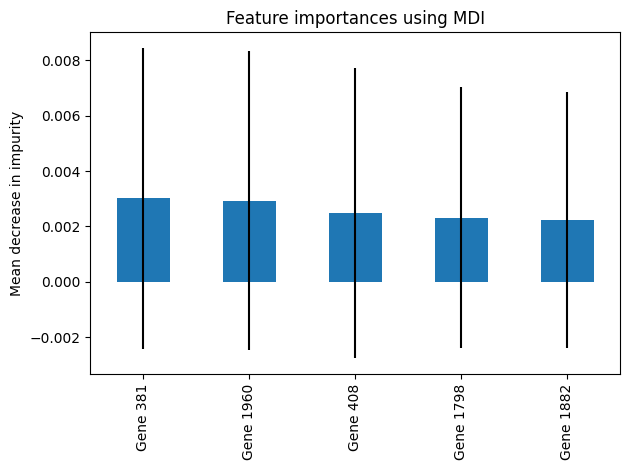

In [20]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
std = np.sort(std)[::-1][:5] # Keep 5 most important features
forest_importances = pd.Series(importances, index=features.columns)
forest_importances = forest_importances.sort_values(ascending=False)[:5] # Keep 5 most important features

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### How these top 5 features are distributed per class

Sources:
- https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
- https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
- https://pandas.pydata.org/docs/user_guide/merging.html

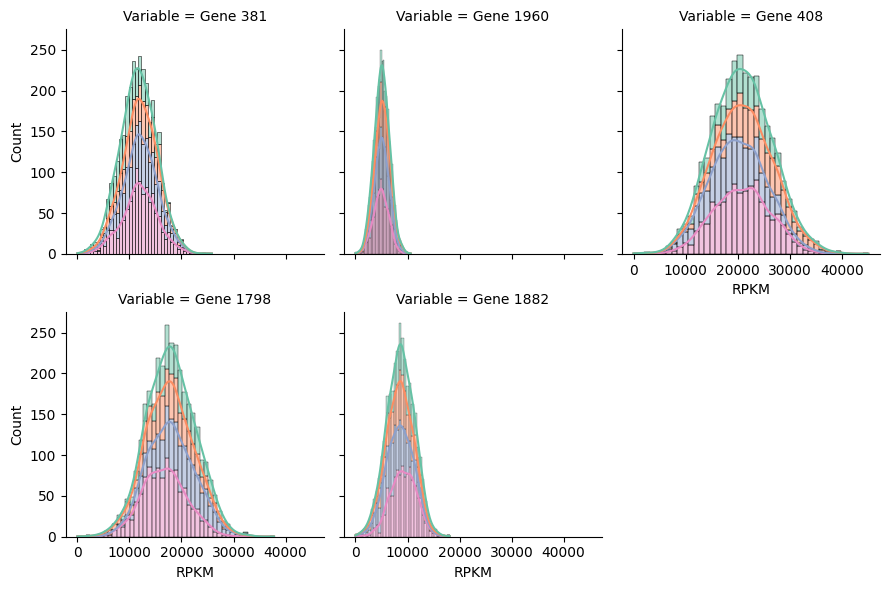

In [21]:
data = features[forest_importances.index] # Filter for most important features
data = pd.concat((data, labels), axis=1) # add labels as a column
data_long = data.melt(id_vars=['Outcome'] ,var_name='Variable', value_name='RPKM') # format data to long format, RPKM =Reads Per Kilobase Mapped

graph = sns.FacetGrid(data_long, col='Variable', col_wrap=3, )
graph.map_dataframe(sns.histplot, x ='RPKM', hue='Outcome', multiple='stack', kde=True, palette='Set2')
plt.show()

# 10 Neural network
Finally, I want you to train a simple feedforward dense/fully-connected neural network on this data. Use ReLU activation functions, and 3 hidden layers with 30, 20, and 10 neurons, and 4 output neurons for the classification (with a softmax activation). Do like we did before: define a function to make your neural net in Keras, make a scikit-learn object out of it, and train it with cross-validation. Don’t perform hyperparameter optimalisation for the neural network here. That could become very time-consuming. Scale the data, but rather than imputing nans just set them all to -1. 

In [22]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Input

In [23]:
#function to build model
def build_neural_net(input_shape=(2000,), hiddenLayerOne=30, hiddenLayerTwo=20, hiddenLayerThree=10, learnRate=0.01):
    # initialize a sequential model and add layer to flatten the input data
    model = Sequential()

    model.add(Input(input_shape))
    model.add(Dense(hiddenLayerOne, activation="relu"))
    model.add(Dropout(0.3))
              
    model.add(Dense(hiddenLayerTwo, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(hiddenLayerThree, activation="relu"))
    model.add(Dropout(0.3))
              
    # add a softmax layer on top
    model.add(Dense(4, activation="softmax"))
              
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learnRate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
              
    # return compiled model
    return model

model = KerasClassifier(model=build_neural_net, verbose=0)

pipe = Pipeline([
    ('normilization', StandardScaler()), 
    ('model', model)
])

# Convert dataframe to numpy array
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_val_array = np.array(X_val)
y_val_array = np.array(y_val)

# Replace Nan values with -1
X_train_array = np.where(np.isnan(X_train_array), -1, X_train_array)
X_val_array = np.where(np.isnan(X_val_array), -1, X_val_array)

# Fit and measure performance
pipe.fit(X_train_array, y_train_array)
scoring = 'accuracy'
score = cross_validate(pipe, X_val_array, y_val_array, cv=5, scoring=scoring)

print(f'Mean validation {scoring} across folds: {round(np.mean(score["test_score"]), 2)}')

Mean validation accuracy across folds: 0.32


In [24]:
# Predict on test set
score = pipe.score(np.array(test_features), np.array(test_labels).flatten())
print(f'{scoring} on test set: {round(score, 2)}')

accuracy on test set: 0.22


# Final classifier
we've chosen to use a random forest as our final classifier because there are many features in our dataset and the Random forest classifier tends to handle those better. 
we'll improve on our earlier trial with some hyperparameter optimization, since we haven't don

In [6]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_val_score, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import time

In [7]:
# train and validation split not needed because those splits happen through nested cross vaidation
X = X_downSampled
y = y_downSampled

In [12]:
# define the pipeline
pipe = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('random_forest', RandomForestClassifier(n_jobs=-2, random_state=global_seed, verbose=1))
])

# hyperparameter grid
param_grid = {
    'random_forest__n_estimators': [100, 250, 500, 1000],
    'random_forest__max_depth': [None, 10, 20, 30, 40, 50],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2']
}
# param_grid = {
#     'random_forest__n_estimators': [100, 250],
#     'random_forest__max_depth': [10, 20]
# }

# nested cross-validation
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=global_seed)
outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=global_seed)

# Scoring
scoring = ['roc_auc_ovr','f1_macro']

# Hyperparameter optimization
grid_search = HalvingGridSearchCV(
    estimator=pipe, 
    param_grid=param_grid, 
    cv=inner_cv, 
    n_jobs=-2, 
    scoring='f1_macro',
    verbose=1
)

# Measuring performance using nested cross validation
print(f"Starting run...")
start_time = time.time()
nested_scores = cross_val_score(
    grid_search, 
    X, 
    y, 
    cv=outer_cv, 
    scoring='f1_macro', 
    n_jobs=-2,
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Run done! Elapsed time: {minutes} min {seconds:.2f} sec")

print(f'Nested CV ROC AUC scores: {nested_scores}')
print(f'Mean ROC AUC score: {np.mean(nested_scores)}')

Starting run...


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Predict on test set
y_pred = pipe.predict(test_features)
y_prob = pipe.predict_proba(test_features)  # for roc_auc

test_scores = {
    'roc_auc_ovr': roc_auc_score(test_labels, y_prob, multi_class='ovr'),
    'f1_macro': f1_score(test_labels, y_pred, average='macro')
    'accuracy': accuracy(test_labels, y_pred)
}

for metric, value in test_scores.items():
    print(f'{metric} on test set: {round(value, 2)}')

# Ideas:
- Plot prediction against Y to get a quick high level  view of the performance
- Consider Halving gridsearch or do randomized search to decrease computation time:
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
- Plot computation time for experiment
- Quantile transform to get rid of outliers
    - Effect of transforms to get a better result. Maybe brute force it?
- plot_output(scaler=scaler) # to get a easy visualisation of what the scaler is doing